# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import seaborn as sns
import sklearn as sk
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [144]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [145]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

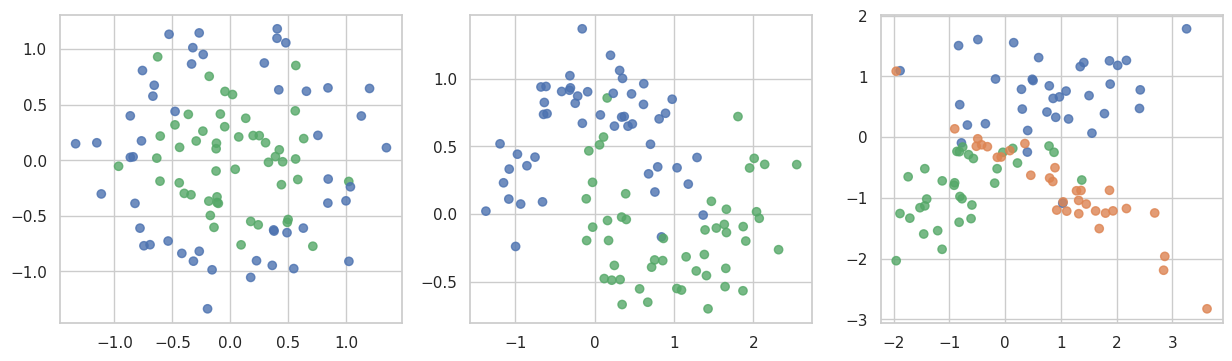

In [146]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [147]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

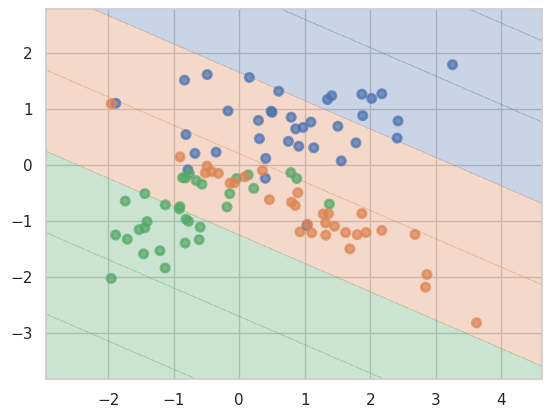

In [148]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

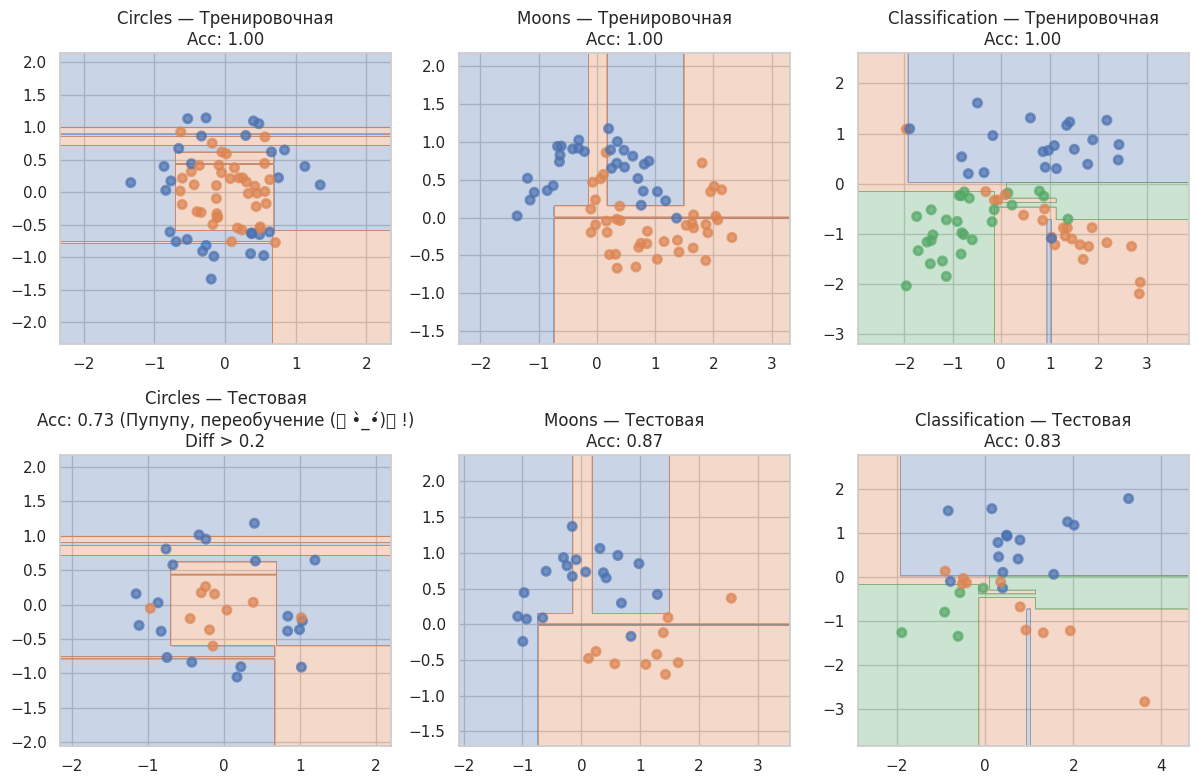

In [149]:
dataset_names = ["Circles", "Moons", "Classification"]
diff = 0.2

plt.figure(figsize=(12, 8))

for i, (x, y) in enumerate(datasets):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,
                                                        random_state=42)

    tree = DecisionTreeClassifier(random_state=42)  # Ответ на великий вопрос… это… это… сорок два
    tree.fit(x_train, y_train)

    train_acc = accuracy_score(y_train, tree.predict(x_train))
    test_acc = accuracy_score(y_test, tree.predict(x_test))
    overfit_note = f" (Пупупу, переобучение (ง •̀_•́)ง !)\nDiff > {diff}" if train_acc - test_acc > diff else ""

    plt.subplot(2, 3, i + 1)
    plot_surface(tree, x_train, y_train)
    plt.title(f"{dataset_names[i]} — Тренировочная\nAcc: {train_acc:.2f}")

    plt.subplot(2, 3, i + 4)
    plot_surface(tree, x_test, y_test)
    plt.title(f"{dataset_names[i]} — Тестовая\nAcc: {test_acc:.2f}{overfit_note}")

plt.tight_layout()
plt.show()


__Ответ:__  Деревья в задании переобучились из-за высокой гибкости, отсутствия ограничений глубины и шума в данных. Это видно и по точности, и по графикам с тонкими разделяющими полосами.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

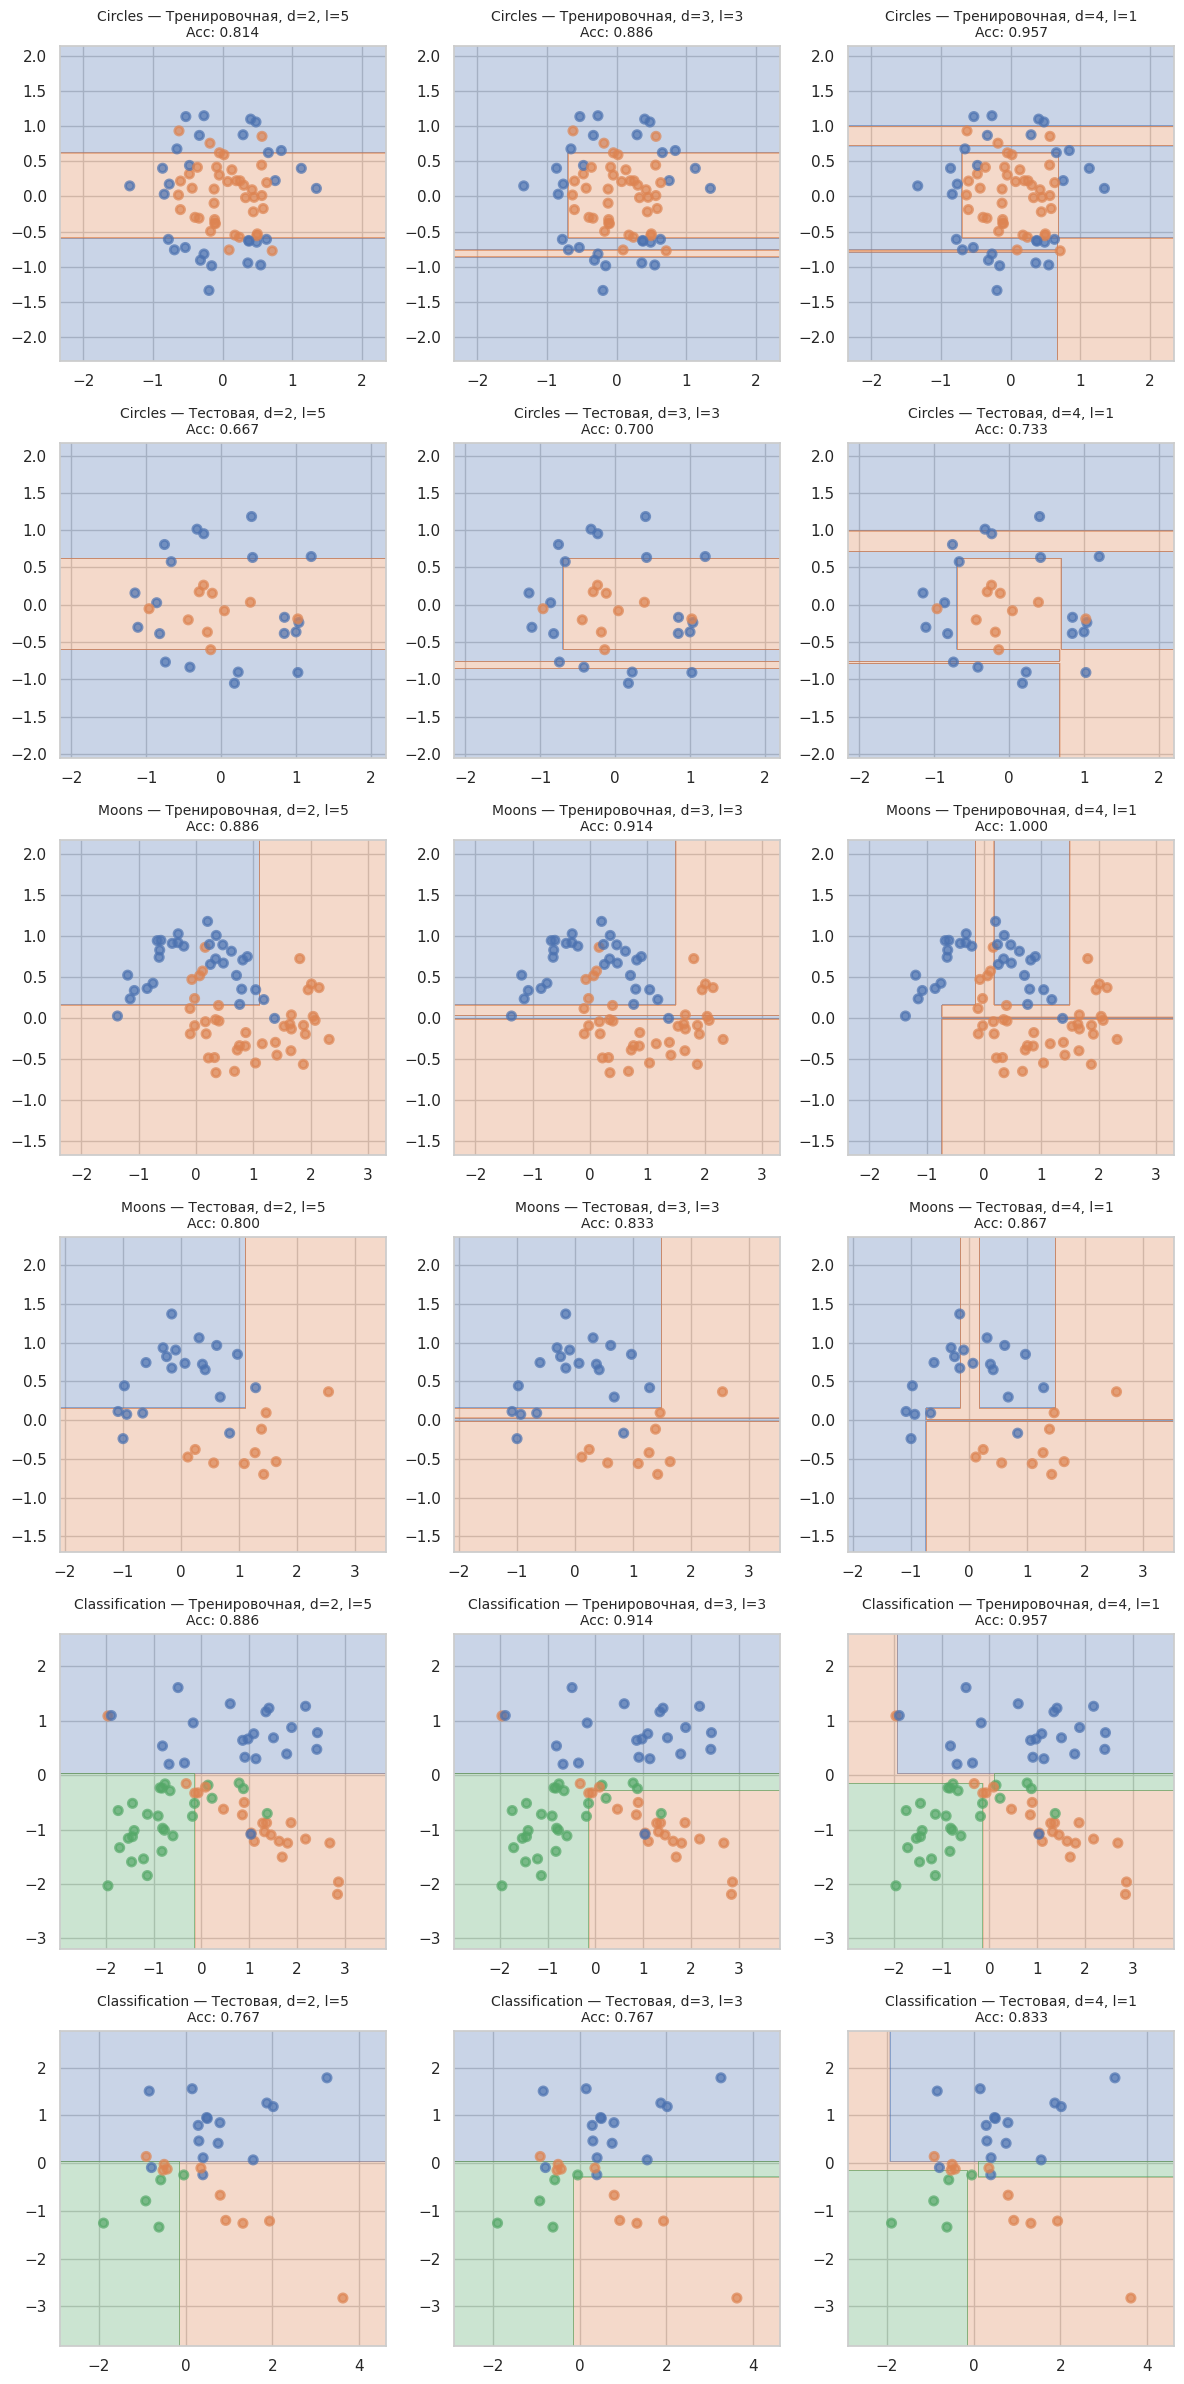

In [150]:
plt.figure(figsize=(12, 24))

for i, (x, y) in enumerate(datasets):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,
                                                        random_state=42)

    #
    tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5, random_state=42)  # Ответ на великий вопрос… это… это… сорок два
    tree.fit(x_train, y_train)
    train_acc = accuracy_score(y_train, tree.predict(x_train))
    test_acc = accuracy_score(y_test, tree.predict(x_test))

    plt.subplot(6, 3, 6*i + 1)
    plot_surface(tree, x_train, y_train)
    plt.title(f"{dataset_names[i]} — Тренировочная, d=2, l=5\nAcc: {train_acc:.3f}", fontsize=10)

    plt.subplot(6, 3, 6*i + 4)
    plot_surface(tree, x_test, y_test)
    plt.title(f"{dataset_names[i]} — Тестовая, d=2, l=5\nAcc: {test_acc:.3f}", fontsize=10)

    #
    tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=42)  # Ответ на великий вопрос… это… это… сорок два
    tree.fit(x_train, y_train)
    train_acc = accuracy_score(y_train, tree.predict(x_train))
    test_acc = accuracy_score(y_test, tree.predict(x_test))

    plt.subplot(6, 3, 6*i + 2)
    plot_surface(tree, x_train, y_train)
    plt.title(f"{dataset_names[i]} — Тренировочная, d=3, l=3\nAcc: {train_acc:.3f}", fontsize=10)

    plt.subplot(6, 3, 6*i + 5)
    plot_surface(tree, x_test, y_test)
    plt.title(f"{dataset_names[i]} — Тестовая, d=3, l=3\nAcc: {test_acc:.3f}",  fontsize=10)

    #
    tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=42)  # Ответ на великий вопрос… это… это… сорок два
    tree.fit(x_train, y_train)
    train_acc = accuracy_score(y_train, tree.predict(x_train))
    test_acc = accuracy_score(y_test, tree.predict(x_test))

    plt.subplot(6, 3, 6*i + 3)
    plot_surface(tree, x_train, y_train)
    plt.title(f"{dataset_names[i]} — Тренировочная, d=4, l=1\nAcc: {train_acc:.3f}", fontsize=10)

    plt.subplot(6, 3, 6*i + 6)
    plot_surface(tree, x_test, y_test)
    plt.title(f"{dataset_names[i]} — Тестовая, d=4, l=1\nAcc: {test_acc:.3f}",  fontsize=10)


plt.tight_layout()
plt.show()


__Ответ:__ При увеличении максимальной глубины и уменьшении минимального количества объектов в листьях дерево становится более гибким, может точнее подстроиться под обучающую выборку и даже выучить шум. Это приводит к усложнению разделяющей поверхности — она становится изломанной, появляются мелкие прямоугольники и тонкие полосы, которые соответствуют переобучению. На графиках видно, как дерево начинает "огибать" каждый кластер. В результате обучающая точность стремится к 1.00, но тестовая точность может снижаться.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

In [151]:
def find_best_split(feature_vector, target_vector):
    x = np.asarray(feature_vector, dtype=float)
    y = np.asarray(target_vector, dtype=int)
    n = x.shape[0]
    if n <= 1:
        return None

    idx = np.argsort(x)
    x_sorted = x[idx]
    y_sorted = y[idx]

    diffs = np.diff(x_sorted)
    valid = diffs != 0
    if not np.any(valid):
        return None

    thresholds = (x_sorted[:-1] + x_sorted[1:]) / 2
    thresholds = thresholds[valid]

    cumsum_pos = np.cumsum(y_sorted)
    total_pos = cumsum_pos[-1]

    left_counts = np.arange(1, n)
    right_counts = n - left_counts

    pos_left = cumsum_pos[:-1]
    pos_right = total_pos - pos_left

    neg_left = left_counts - pos_left
    neg_right = right_counts - pos_right

    pL1 = pos_left / left_counts
    pL0 = neg_left / left_counts
    pR1 = pos_right / right_counts
    pR0 = neg_right / right_counts

    H_left = 1 - pL1**2 - pL0**2
    H_right = 1 - pR1**2 - pR0**2

    weighted_impurity = (left_counts / n) * H_left + (right_counts / n) * H_right
    ginis_all = -weighted_impurity
    ginis = ginis_all[valid]

    if ginis.size == 0:
        return None

    best_idx = np.argmax(ginis)
    threshold_best = thresholds[best_idx]
    gini_best = ginis[best_idx]

    return thresholds, ginis, threshold_best, gini_best


__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [152]:
### (╯°□°）╯︵ ┻━┻
df = pd.read_csv('students.csv')
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


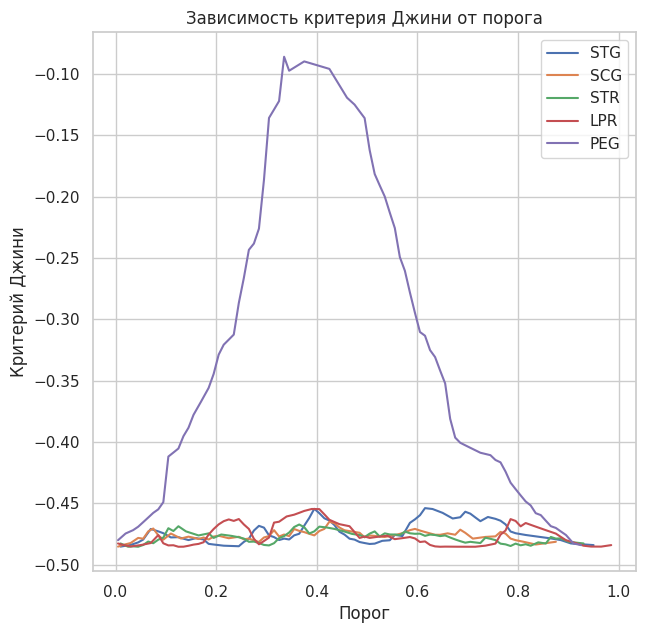

In [153]:
plt.figure(figsize=(7,7))
plt.xlabel('Порог')
plt.ylabel('Критерий Джини')

feature_cols = ['STG','SCG','STR','LPR','PEG']
target_col = 'UNS'
x = df[feature_cols]
y = df[target_col]

for col in x:
  thresholds, ginis, _, _ = find_best_split(df[col], y)
  plt.plot(thresholds, ginis, label=col)
  plt.title('Зависимость критерия Джини от порога')

plt.legend();

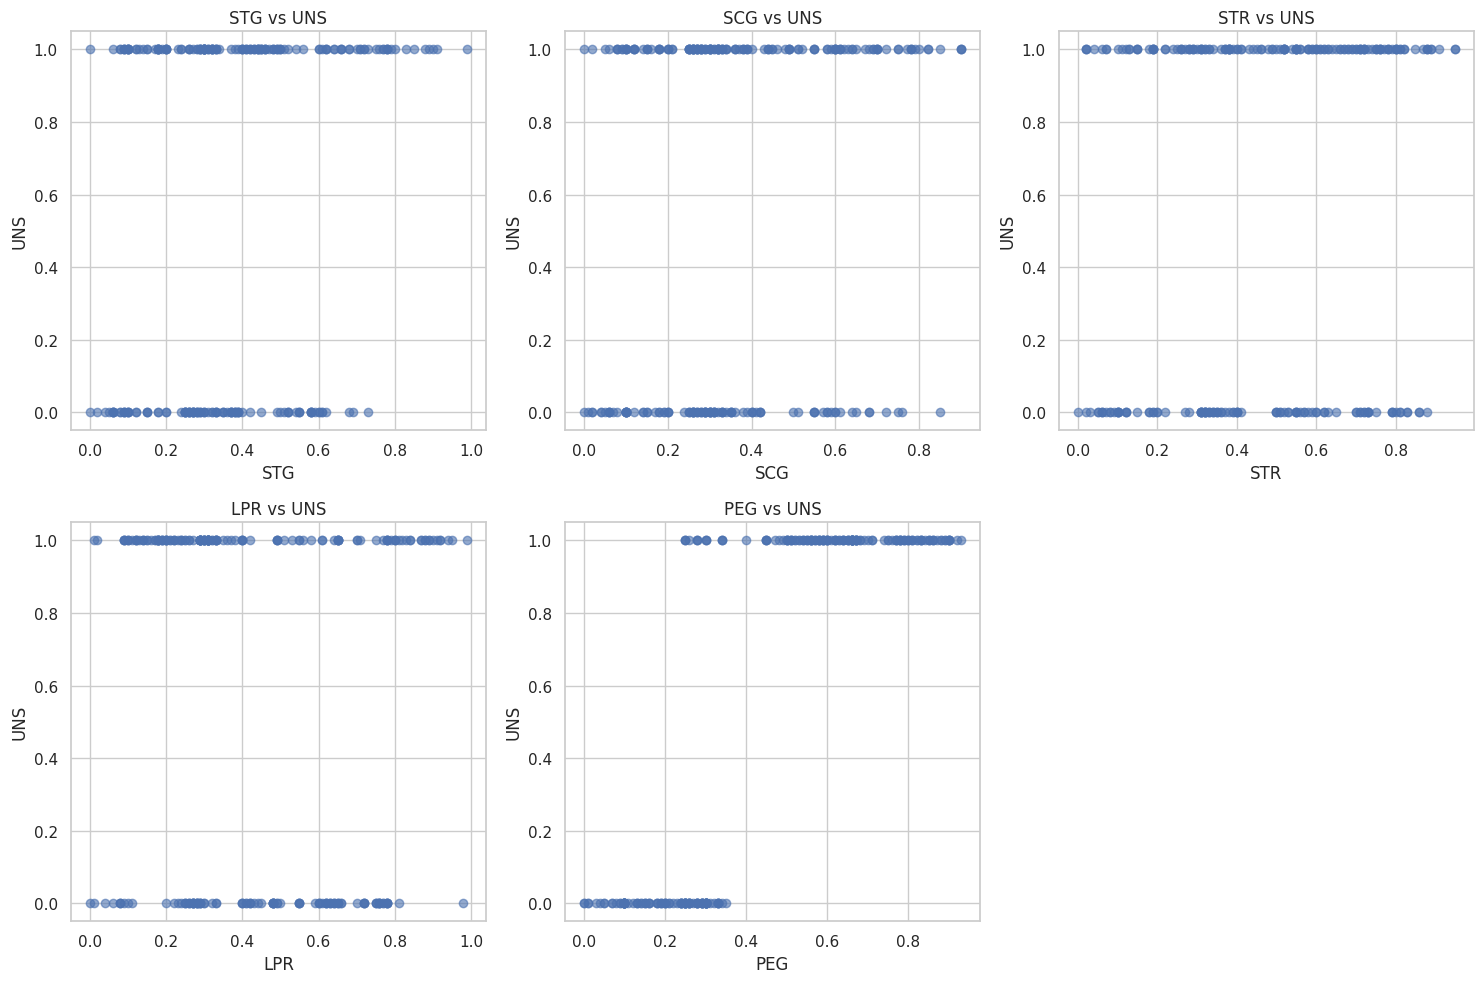

In [154]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, feature_cols):
    ax.scatter(df[col], df[target_col], alpha=0.6)
    ax.set_xlabel(col)
    ax.set_ylabel('UNS')
    ax.set_title(f'{col} vs UNS')
    ax.grid(True)

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Признак PEG оказался самым информативным. Кривая образует "холм" с ярко выраженным максимумом около 0.4, и на scatter-графике видно, что при PEG = примерно 0.4 точки классов почти полностью разделяются. По остальным признакам кривая Джини почти плоская, без выраженных пиков, а точки классов на графиках смешаны, поэтому никакой порог не даёт чёткого разделения выборки. Чем более симметрична и сконцентрирована форма кривой с одним пиком, тем легче получить точное деление; а если линия сглажена и колеблется без явных экстремумов, то такие признаки не годятся для простого сплита.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

In [155]:
class DecisionTree:
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._depth = 0
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node):
        if np.all(sub_y == sub_y[0]): #fixed
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        if self._max_depth is not None and node["depth"] > self._max_depth:
          node["type"] = "terminal"
          node["class"] = Counter(sub_y).most_common(1)[0][0]
          return

        if self._min_samples_split is not None and len(sub_y) < self._min_samples_split:
          node["type"] = "terminal"
          node["class"] = Counter(sub_y).most_common(1)[0][0]
          return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(1, sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_click/current_count #fix
                sorted_categories = list(map(lambda x: x[0], sorted(ratio.items(), key=lambda x: x[1]))) #fixed
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))

                feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
            else:
                raise ValueError

            if len(feature_vector) == 3:
                continue


            split_result = find_best_split(feature_vector, sub_y)
            if split_result is None:
                continue
            _, _, threshold, gini = split_result
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical": #fix
                    threshold_best = list(map(lambda x: x[0],
                                              filter(lambda x: x[1] < threshold, categories_map.items())))
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node['class'] = Counter(sub_y).most_common(1)[0][0] #fix
            return

        left_indices = split
        right_indices = np.logical_not(split)

        if self._min_samples_leaf is not None:
            if np.sum(left_indices) < self._min_samples_leaf or np.sum(right_indices) < self._min_samples_leaf:
                node["type"] = "terminal"
                node["class"] = Counter(sub_y).most_common(1)[0][0]
                return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best

        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        node["left_child"]["depth"] = node["depth"] + 1
        node["right_child"]["depth"] = node["depth"] + 1
        self._depth = max(self._depth, node["depth"] + 1)

        self._fit_node(sub_X[left_indices], sub_y[left_indices], node["left_child"])
        self._fit_node(sub_X[right_indices], sub_y[right_indices], node["right_child"])

    def _predict_node(self, x, node):
      if node["type"] == "terminal":
          return node["class"]

      feature = node["feature_split"]
      feature_type = self._feature_types[feature]

      if feature_type == "real":
          if x[feature] < node["threshold"]:
              return self._predict_node(x, node["left_child"])
          else:
              return self._predict_node(x, node["right_child"])
      elif feature_type == "categorical":
          if x[feature] in node["categories_split"]:
              return self._predict_node(x, node["left_child"])
          else:
              return self._predict_node(x, node["right_child"])
      else:
          raise ValueError("Unknown feature type")

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self._tree = {}
        self._tree["depth"] = 1
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        X = np.array(X)
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [156]:
### (◕‿◕✿)

#df = pd.read_csv('agaricus-lepiota.data')
#df.head()

df = pd.read_csv("agaricus-lepiota.data", header=None)
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
df.head()

x = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

feature_types = ["categorical"] * x.shape[1]

tree = DecisionTree(feature_types=feature_types)
tree.fit(x_train, y_train)

y_pred = tree.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2}")
print(f"Depth: {tree._depth}")


Accuracy: 1.0
Depth: 8


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

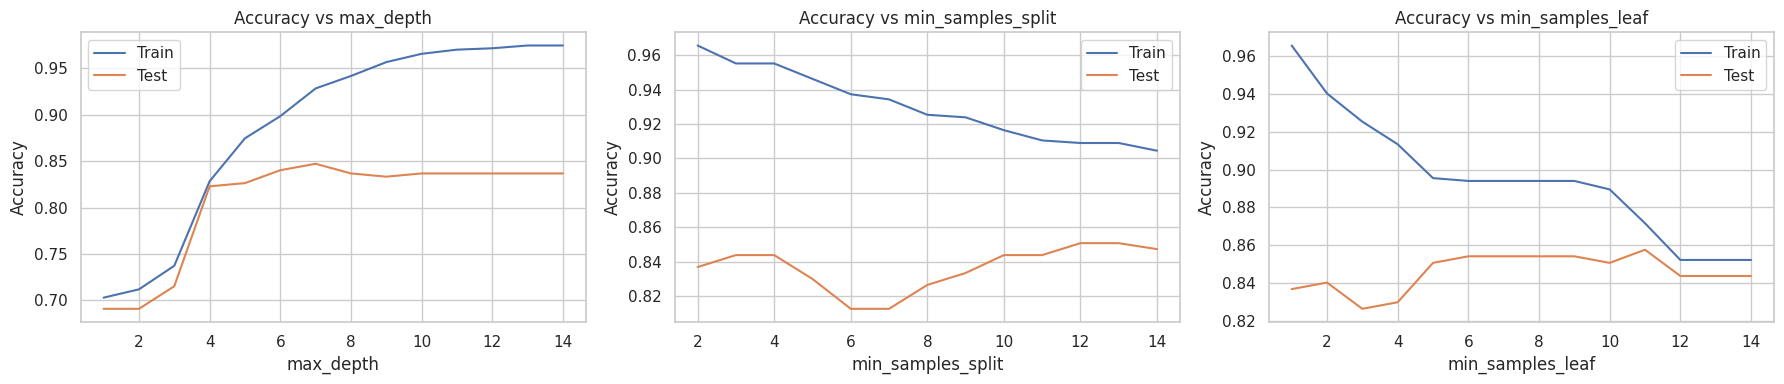

In [157]:
df = pd.read_csv('tic-tac-toe-endgame.csv')
x = df.drop('V10', axis=1).apply(LabelEncoder().fit_transform).values
y = (df['V10'] == 'positive').astype(int).values
feature_types = ['categorical'] * x.shape[1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

params = [
    ('max_depth', range(1, 15)),
    ('min_samples_split', range(2, 15)),
    ('min_samples_leaf', range(1, 15))
]

fig, axs = plt.subplots(1, 3, figsize=(18, 4))

for ax, (name, values) in zip(axs, params):
    train_scores = []
    test_scores = []

    for val in values:
        tree = DecisionTree(
            feature_types=feature_types,
            max_depth=val if name == 'max_depth' else 10,
            min_samples_split=val if name == 'min_samples_split' else 2,
            min_samples_leaf=val if name == 'min_samples_leaf' else 1
        )
        tree.fit(x_train, y_train)
        train_scores.append(accuracy_score(y_train, tree.predict(x_train)))
        test_scores.append(accuracy_score(y_test, tree.predict(x_test)))

    ax.plot(values, train_scores, label='Train')
    ax.plot(values, test_scores, label='Test')
    ax.set_xlabel(name, fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'Accuracy vs {name}')
    ax.legend()

plt.tight_layout()
plt.show()


__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [158]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
mushrooms_df = pd.read_csv('agaricus-lepiota.data', header=None)
mushrooms_df.head()


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [165]:
tic_tac_toe_df = pd.read_csv('tic-tac-toe-endgame.csv')
tic_tac_toe_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [160]:
cars_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
cars_df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [161]:
nursery_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header=None)
nursery_df.head()

,0,1,2,3,4,5,6,7,8
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In [162]:
mushrooms_target = mushrooms_df.columns[0]
mushrooms_df[mushrooms_target] = mushrooms_df[mushrooms_target].map({'p': 0, 'e': 1})

tic_tac_toe_target = tic_tac_toe_df.columns[-1]
tic_tac_toe_df[tic_tac_toe_target] = tic_tac_toe_df[tic_tac_toe_target].map({'negative': 0, 'positive': 1})

cars_target = cars_df.columns[-1]
cars_df[cars_target] = cars_df[cars_target].map({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})

nursery_target = nursery_df.columns[-1]
nursery_df[nursery_target] = nursery_df[nursery_target].map(
    {'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1})

def encode_features(df, target_column):
    df_encoded = df.copy()
    for col in df.columns:
        if col != target_column:
            df_encoded[col] = LabelEncoder().fit_transform(df[col])
    return df_encoded

mushrooms_df = encode_features(mushrooms_df, mushrooms_target)
tic_tac_toe_df = encode_features(tic_tac_toe_df, tic_tac_toe_target)
cars_df = encode_features(cars_df, cars_target)
nursery_df = encode_features(nursery_df, nursery_target)

In [163]:
class RealDecisionTree:
  def fit(self, x, y):
    self._tree = DecisionTree(['real'] * x.shape[1])
    self._tree.fit(x, y)

  def predict(self, x):
    return self._tree.predict(x)

  def get_params(self, deep=True):
    return {}

class CategoricalDecisionTree:
  def fit(self, x, y):
    self._tree = DecisionTree(['categorical'] * x.shape[1])
    self._tree.fit(x, y)

  def predict(self, x):
    return self._tree.predict(x)

  def get_params(self, deep=True):
    return {}

class OneHotDecisionTree:
  def __init__(self):
    self._encoder = sk.preprocessing.OneHotEncoder(sparse_output=False)

  def fit(self, x, y):
    x = self._encoder.fit_transform(x)
    self._tree = DecisionTree(['real'] * x.shape[1])
    self._tree.fit(x, y)

  def predict(self, x):
    x = self._encoder.transform(x)
    return self._tree.predict(x)

  def get_params(self, deep=True):
    return {}

In [164]:
datasets = {
    "mushrooms": (mushrooms_df.drop(columns=[mushrooms_target]), mushrooms_df[mushrooms_target]),
    "tic_tac_toe": (tic_tac_toe_df.drop(columns=[tic_tac_toe_target]), tic_tac_toe_df[tic_tac_toe_target]),
    "cars": (cars_df.drop(columns=[cars_target]), cars_df[cars_target]),
    "nursery": (nursery_df.drop(columns=[nursery_target]), nursery_df[nursery_target])
}

results = pd.DataFrame(index=datasets.keys(),
                       columns=["real", "categorical", "one_hot", "sklearn_dt"])

for name, (X, y) in datasets.items():
    real_scores = cross_val_score(RealDecisionTree(), X, y, cv=10, scoring=make_scorer(accuracy_score))
    results.loc[name, "real"] = real_scores.mean()

    cat_scores = cross_val_score(CategoricalDecisionTree(), X, y, cv=10, scoring=make_scorer(accuracy_score))
    results.loc[name, "categorical"] = cat_scores.mean()

    one_hot_scores = cross_val_score(OneHotDecisionTree(), X, y, cv=10, scoring=make_scorer(accuracy_score))
    results.loc[name, "one_hot"] = one_hot_scores.mean()

    sklearn_scores = cross_val_score(DecisionTreeClassifier(), X, y, cv=10, scoring=make_scorer(accuracy_score))
    results.loc[name, "sklearn_dt"] = sklearn_scores.mean()

results

,real,categorical,one_hot,sklearn_dt
mushrooms,0.999261,1.0,1.0,0.956689
tic_tac_toe,0.680219,0.752226,0.563344,0.762325
cars,0.86561,0.86561,0.928761,0.943285
nursery,0.999537,0.999537,0.999614,0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** Ранжирование алгоритмов зависит от набора данных: на mushrooms и nursery все модели почти идеальны, а на tic_tac_toe заметна разница. Это связано с различиями в сложности признаков и разделимости классов. Так же есть элемент случайности — при выборе порога используется random seed. Результаты могут быть улучшены. Например, с помощью настройки глубины дерева и размера узлов.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

乁( •_• )ㄏ

(╯°益°)╯︵╰(◉‿◉)╮

(ᇂ_ᇂ)╯︵ ┻━┻